## Kobe Bryant Shot Prediction 

This notebook serves as an introduction to Kaggle competition through the (now-closed) Kobe Bryant Shot Selection competition through Kaggle, whose data is availible here: https://www.kaggle.com/c/kobe-bryant-shot-selection/data

This documents different classification algorithms including Logistic Regression, Random Forests, Neural Networks, Support Vector Machines and Naive Bayes, all through the Scikit-Learn library, availible here: http://scikit-learn.org/stable/index.html

I used the NumPy package for various computations and transformations and the MatPlotLib package for visualization via the Pandas plotting commands. 

I *didn't actually* submit any of these as my final models; mine was a more complex Random Forest that didn't overfit the data. 

Here I pull out 5,000 observations for cross-validation and tune my parameters by minimizing the log-loss function. Since it's only 1 cross-validation set, I inevitably overfit to those observations. The best log-loss score by my test data was around .602, but the best for the submission was .612. That score was good enough to *almost* make it into the top half of the entries. 

The submission I turned into the competition used somewhat different features and scored .60702, which placed me in 397th position. 

The competition wanted the data as a .csv file with the shot to predict in the first column and the probability that Kobe made that shot calculated by the algorithm in the second column. I used the Pandas .to_csv function and a Python dictionary to get put those together. 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kobe = pd.read_csv('~/downloads/data.csv')

In [3]:
kobe.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
kobe.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [5]:
# Making a list of all the indecies that for the shots we need to predict
test_shot_index = kobe['shot_made_flag'].index[kobe['shot_made_flag'].apply(np.isnan)].tolist()

# the indecies in Pandas start at 0 but Kaggle wants them to start at 1
test_shot_index = [test_shot_index[i] + 1 for i in range(len(test_shot_index))]
print len(test_shot_index)

5000


### Breaking up Categorical Variables in Varibles that I want to Study

In [6]:
# Was Kobe Away or at Home?
kobe['away'] = map(lambda x: True if '@' in x else False, kobe['matchup'])

# When did Kobe Play this Game?
kobe['month'] = kobe['game_date'].str[5:-3]
kobe['year'] = kobe['game_date'].str[:4].astype(int)
kobe['month_year'] = kobe['game_date'].str[:-3]

# How much time was left in the period when he took this shot?
kobe['seconds_remaining'] = kobe.minutes_remaining*60 + kobe.seconds_remaining

# What kobe playing in overtime when he took the shot?
kobe['overtime'] = map(lambda x: True if x > 4 else False, kobe['period'])

In [7]:
# Make each element in the categorical column it's own predictor 

# Type of shot taken
for elem in kobe['action_type'].unique(): 
    kobe[str(elem)] = kobe['action_type'] == elem

# Another type of shot taken
for elem in kobe['combined_shot_type'].unique():
    kobe[str(elem)] = kobe['combined_shot_type'] == elem

# General area of the court
for location in kobe['shot_zone_area'].unique():
    kobe[str(location)] = kobe['shot_zone_area'] == location

# Another general area of the court 
for location in kobe['shot_zone_basic'].unique():
    kobe[str(location)] = kobe['shot_zone_basic'] == location

# What month did he play the game? (Maybe he wears out over the season or performs worse in the middle)
for mon in kobe['month'].unique():
    kobe[str(mon)] = kobe['month'] == mon
    
# What year did he play?
for annual in kobe['year'].unique():
    kobe[str(annual)] = kobe['year'] == annual
    
# What season was the game?
for seas in kobe['season'].unique():
    kobe[str(seas)] = kobe['season'] == seas
    
# What team did he play?
for team in kobe['opponent'].unique():
    kobe[str(team)] = kobe['opponent'] == team
    
# What does the data look like now?
print kobe.describe()

# How many columns do we currently have?
print len(kobe.columns)

       game_event_id       game_id           lat         loc_x         loc_y  \
count   30697.000000  3.069700e+04  30697.000000  30697.000000  30697.000000   
mean      249.190800  2.476407e+07     33.953192      7.110499     91.107535   
std       150.003712  7.755175e+06      0.087791    110.124578     87.791361   
min         2.000000  2.000001e+07     33.253300   -250.000000    -44.000000   
25%       110.000000  2.050008e+07     33.884300    -68.000000      4.000000   
50%       253.000000  2.090035e+07     33.970300      0.000000     74.000000   
75%       368.000000  2.960047e+07     34.040300     95.000000    160.000000   
max       659.000000  4.990009e+07     34.088300    248.000000    791.000000   

                lon  minutes_remaining        period      playoffs  \
count  30697.000000       30697.000000  30697.000000  30697.000000   
mean    -118.262690           4.885624      2.519432      0.146562   
std        0.110125           3.449897      1.153665      0.353674   

In [8]:
print len(kobe)/len(kobe.columns) # How many observations do I have for each column?

165


### Making New Data Frames

I want a data frame that I can build plots from that describe everything I know and train my final models based on: kobe_known

I want a data farme that I holds the information for the values that I need to predict for the final submission:
kobe_target

I need a data frame that I can train on locally so I tune the machine learning parameters:
kobe_train

I need a data frame that I can test on locally so I can avoid overfitting:
kobe_test

In [9]:
# Creating kobe_target by sifting out shots where the outcome is 0 and then shots where the outcome is nan
kobe_target = kobe[kobe.shot_made_flag != 0]
kobe_target = kobe_target[kobe_target.shot_made_flag != 1]

# Creating the Data frame that I have all the information for 
kobe_known = kobe.dropna()

# Creating my test data frame 
import random
random.seed(321)
random_obs = random.sample(range(len(kobe_known)), 5000) # this function avoids repeats 
kobe_test = kobe_known.iloc[random_obs]

# Creating my training data frame where I just removed the test observations
kobe_train = kobe_known.drop(kobe_known.index[random_obs])

### Vizualizing the Data



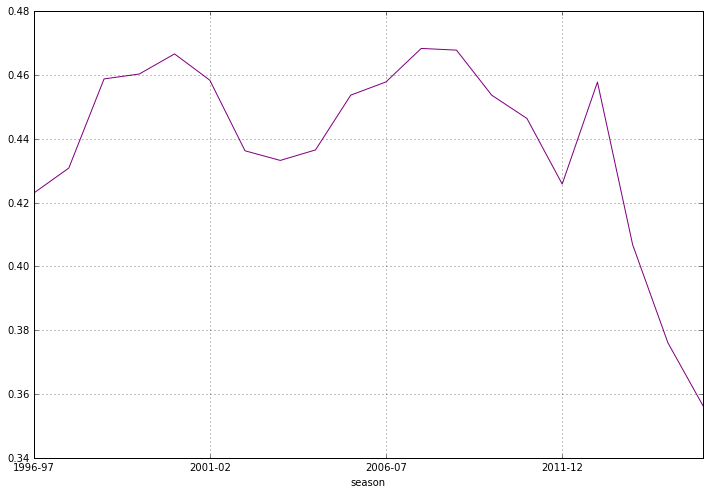

In [10]:
# How did his accuracy very by season?
seasons = kobe_known.groupby('season')['shot_made_flag'].mean()
seasons.plot(kind = 'line', color = "Purple", grid = True, figsize = (12, 8))

He held realitively steady except for the end of his career. The years should definitely be included

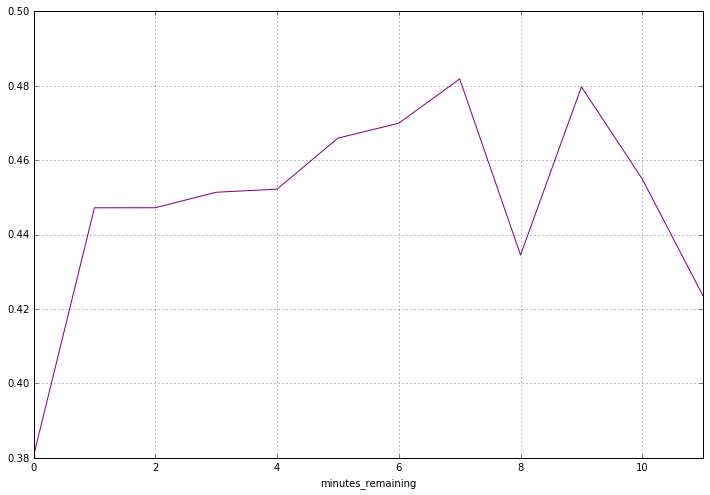

In [11]:
# How did his accuracy vary over the period?
time = kobe_known.groupby('minutes_remaining')['shot_made_flag'].mean()
time.plot(kind = 'line', color = "Purple", grid = True,figsize = (12, 8))

Very minor changes with a low of around .43 and a high around .48. The effect size on this probably won't matter much



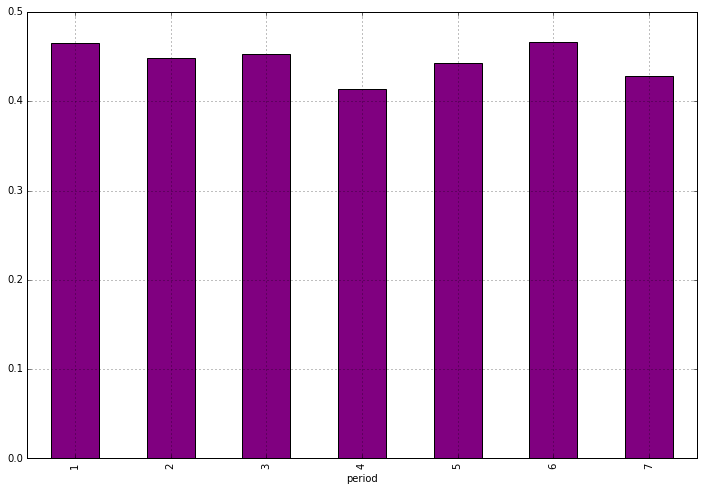

In [12]:
# How did things go period-by-period?
period = kobe_known.groupby('period')['shot_made_flag'].mean()
period.plot(kind = 'bar', color = "Purple", grid = True, figsize = (12, 8))

He dipped towards the end of the game but he otherwise held steady

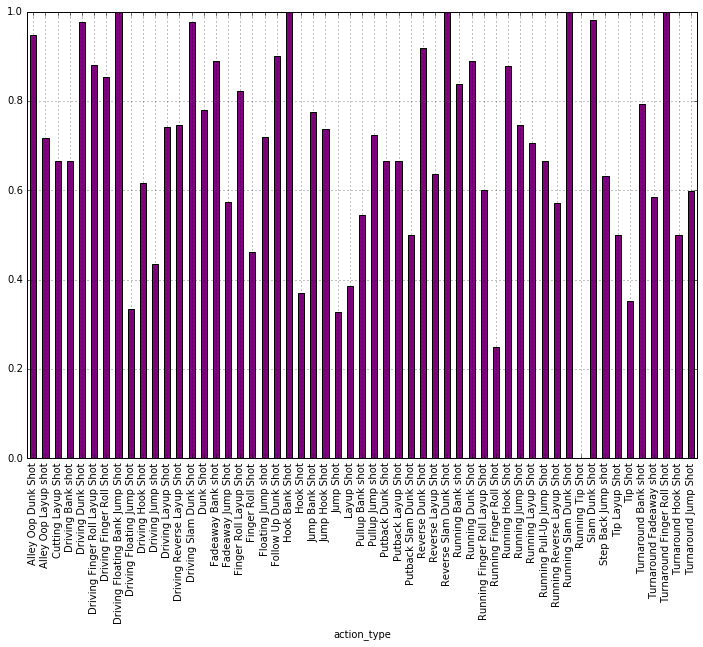

In [13]:
# How did his accuracy vary by the type of shot he took?
shots = kobe_known.groupby('action_type')['shot_made_flag'].mean()
shots.plot(kind = 'bar', color = "Purple", grid = True, figsize = (12, 8))

He was definitely better at some shots than others. 

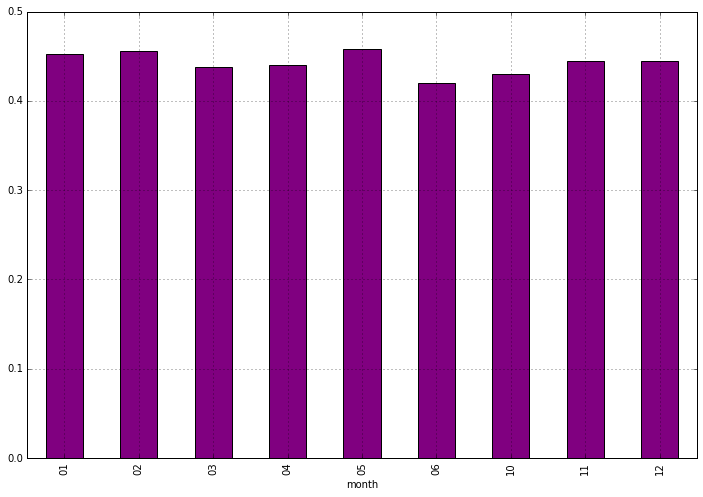

In [14]:
# Did his accuracy change over the course of the year?
month_year = kobe_known.groupby('month')['shot_made_flag'].mean()
month_year.plot(kind = 'bar', color = "Purple", grid = True, figsize = (12, 8))

He plays better in the early part of the playoffs (May) than in the latter part of the playoffs (June). It may be worth it to only inlcude dummy variables for may and June or just keep all the dummy variables for the month

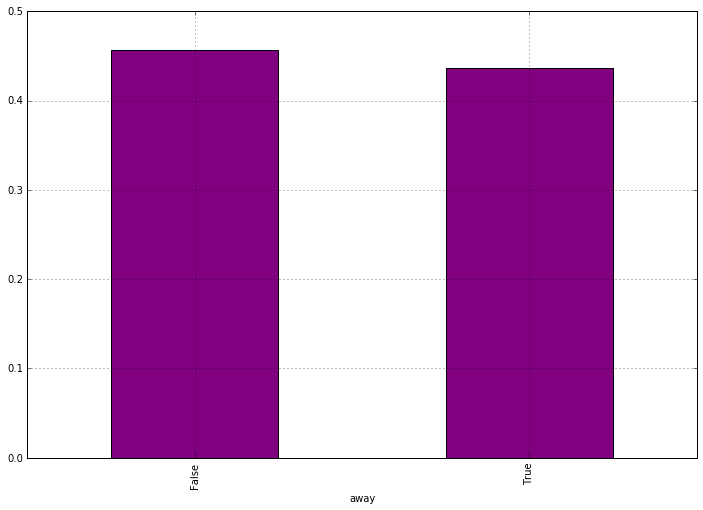

In [15]:
# Did he play better on his home court?
home_v_away = kobe_known.groupby('away')['shot_made_flag'].mean()
home_v_away.plot(kind = 'bar', color = "Purple", grid = True, figsize = (12, 8))

He did play better at home than away

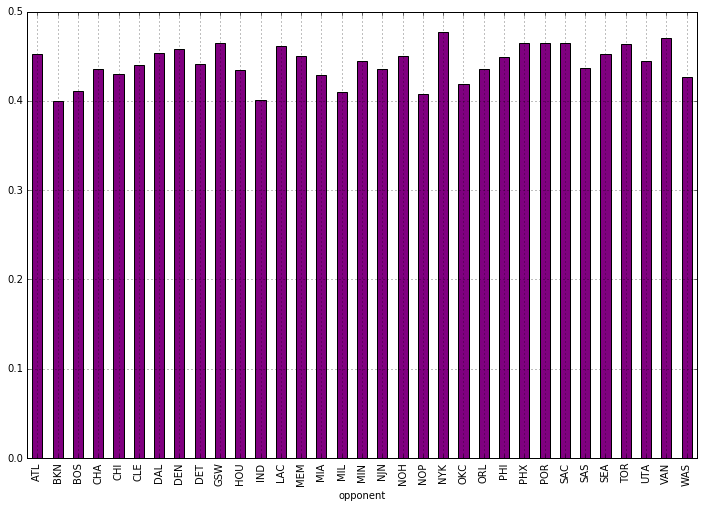

In [16]:
# How did he fair against different teams?
teams = kobe_known.groupby('opponent')['shot_made_flag'].mean()
teams.plot(kind = 'bar', color = "Purple", grid = True, figsize = (12, 8))

All between .40 and .45. I'll use it in an extended model and see how it overfits the data

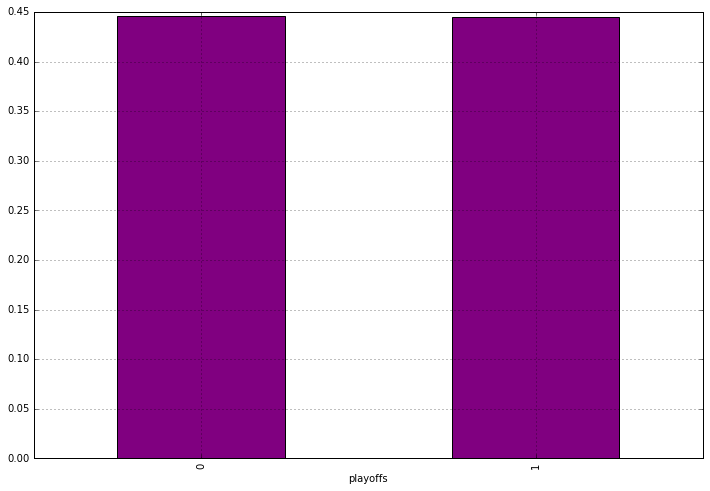

In [17]:
# How does he fair in playoffs vs. regular season?
playoff_games = kobe_known.groupby('playoffs')['shot_made_flag'].mean()
playoff_games.plot(kind = 'bar', color = "Purple", grid = True, figsize = (12, 8))

Almost exactly the same. It may be worth it to lump all the months except May and June together and three dummy variables. Even though April is considered a playoff month, if the Lakers were definitely in or not in Kobe probably didn't play as much or didn't plays as hard but then played really well for the rest of April. That may be why April is more like the other regular season months than the May and June

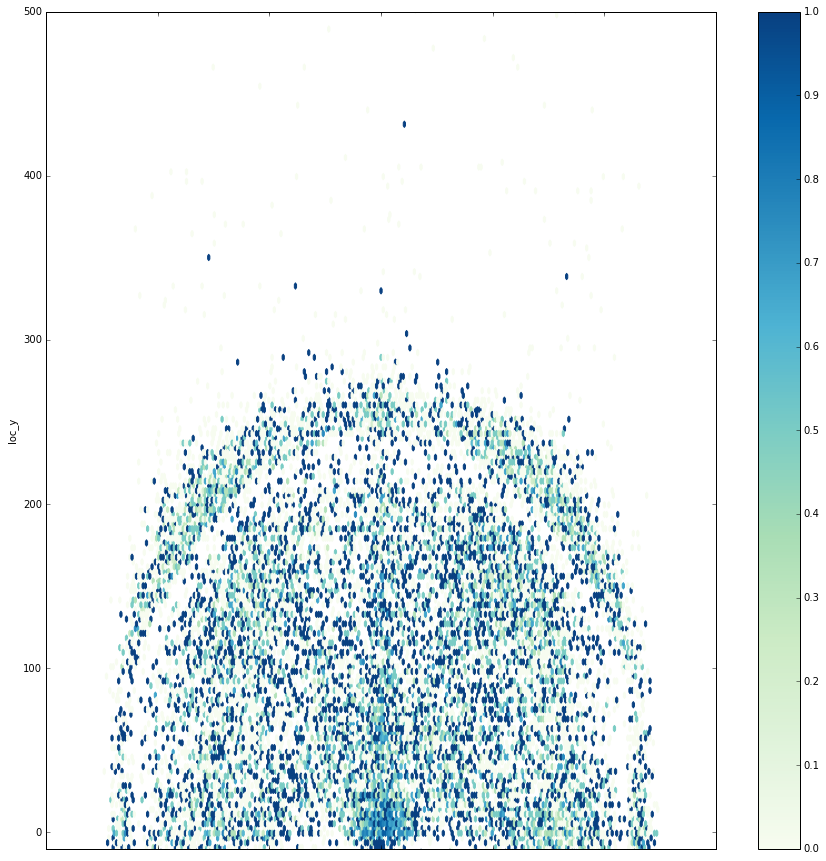

In [18]:
# How did Kobe shoot in different areas of the court?
kobe_known.plot.hexbin(x = 'loc_x', y = 'loc_y', C = 'shot_made_flag', 
                       figsize = (15, 15), xlim = (-300, 300), ylim = (-10, 500), 
                       reduce_C_function = np.mean, cmap = 'GnBu', gridsize = 250)


This variable seems important 

In [19]:
for column in kobe.columns:
    print column

action_type
combined_shot_type
game_event_id
game_id
lat
loc_x
loc_y
lon
minutes_remaining
period
playoffs
season
seconds_remaining
shot_distance
shot_made_flag
shot_type
shot_zone_area
shot_zone_basic
shot_zone_range
team_id
team_name
game_date
matchup
opponent
shot_id
away
month
year
month_year
overtime
Jump Shot
Driving Dunk Shot
Layup Shot
Running Jump Shot
Driving Layup Shot
Reverse Layup Shot
Reverse Dunk Shot
Slam Dunk Shot
Turnaround Jump Shot
Tip Shot
Running Hook Shot
Alley Oop Dunk Shot
Dunk Shot
Alley Oop Layup shot
Running Dunk Shot
Driving Finger Roll Shot
Running Layup Shot
Finger Roll Shot
Fadeaway Jump Shot
Follow Up Dunk Shot
Hook Shot
Turnaround Hook Shot
Running Tip Shot
Jump Hook Shot
Running Finger Roll Shot
Jump Bank Shot
Turnaround Finger Roll Shot
Hook Bank Shot
Driving Hook Shot
Running Reverse Layup Shot
Driving Finger Roll Layup Shot
Fadeaway Bank shot
Pullup Jump shot
Finger Roll Layup Shot
Turnaround Fadeaway shot
Driving Reverse Layup Shot
Driving Slam Du

### Training my models and testing for overfitting

We'll use a log loss formula to examine the scores

In [20]:
# Features I want to train my models on

features = ['loc_x', 'loc_y', 'minutes_remaining', 'period', 
            'away', '1996', '1997', '1998', '1999', '2000', '2001', 
            '2002', '2003', '2004', '2005', '2006', '2007', '2008',
            '2009', '2010', '2011', '2012', '2013', '2014', '2015',
            '2016', '05', '06', 'Jump Shot', 'POR', 'UTA', 'VAN', 
            'LAC','HOU', 'SAS', 'DEN', 'SAC', 'CHI', 'GSW', 'MIN',
            'IND', 'SEA','DAL', 'PHI','DET','MIL','TOR','MIA',
            'PHX', 'CLE', 'NJN', 'NYK', 'CHA', 'WAS', 'ORL', 'ATL',
            'MEM', 'BOS', 'NOH', 'NOP', 'OKC', 'BKN',
            'Driving Dunk Shot', 'Layup Shot', 'Running Jump Shot',
            'Driving Layup Shot', 'Reverse Layup Shot', 'Reverse Dunk Shot',
            'Slam Dunk Shot', 'Turnaround Jump Shot', 'Tip Shot',
            'Running Hook Shot', 'Alley Oop Dunk Shot', 'Dunk Shot',
            'Alley Oop Layup shot', 'Running Dunk Shot',
            'Driving Finger Roll Shot', 'Running Layup Shot',
            'Finger Roll Shot', 'Fadeaway Jump Shot', 'Follow Up Dunk Shot',
            'Hook Shot', 'Turnaround Hook Shot', 'Running Tip Shot',
            'Jump Hook Shot', 'Running Finger Roll Shot', 'Jump Bank Shot',
            'Turnaround Finger Roll Shot', 'Hook Bank Shot',
            'Driving Hook Shot', 'Running Reverse Layup Shot',
            'Driving Finger Roll Layup Shot', 'Fadeaway Bank shot',
            'Pullup Jump shot', 'Finger Roll Layup Shot',
            'Turnaround Fadeaway shot', 'Driving Reverse Layup Shot',
            'Driving Slam Dunk Shot', 'Step Back Jump shot',
            'Reverse Slam Dunk Shot', 'Turnaround Bank shot',
            'Running Finger Roll Layup Shot', 'Floating Jump shot',
            'Putback Slam Dunk Shot', 'Running Bank shot', 'Driving Bank shot',
            'Putback Layup Shot', 'Driving Jump shot', 'Putback Dunk Shot',
            'Pullup Bank shot', 'Running Slam Dunk Shot', 'Cutting Layup Shot',
            'Driving Floating Jump Shot', 'Running Pull-Up Jump Shot',
            'Tip Layup Shot', 'Driving Floating Bank Jump Shot',
            'Turnaround Fadeaway Bank Jump Shot', 'Cutting Finger Roll Layup Shot']

In [21]:
# Extracting the values that I want to train my models on and I'll test those features with the models I run

training_features = kobe_train[features].values
test_features = kobe_test[features].values
made_shot_training = kobe_train['shot_made_flag'].values
made_shot_test = kobe_test['shot_made_flag'].values

In [22]:
from sklearn.metrics import log_loss

### Logistic Regression Classifier

In [23]:
from sklearn.linear_model import LogisticRegression

logistic_train_1 = LogisticRegression(random_state = 321)
logistic_train_1.fit(training_features, made_shot_training)
logistic_predictions_1 = logistic_train_1.predict_proba(test_features) # Kaggle wants the probability of the shots
logistic_1_performance = log_loss(made_shot_test, logistic_predictions_1)

print logistic_1_performance

0.610493046316


In [24]:
log_2 = LogisticRegression(penalty = 'l1', C = .6, random_state = 321)
log_2.fit(training_features, made_shot_training)
log_2_preds = log_2.predict_proba(test_features)
log_2_performance = log_loss(made_shot_test, log_2_preds)

print log_2_performance

0.610195588497


In [25]:
log_3 = LogisticRegression(penalty = 'l1', random_state = 321)
log_3.fit(training_features, made_shot_training)
log_3_preds = log_3.predict_proba(test_features)
log_3_performance = log_loss(made_shot_test, log_3_preds)

print log_3_performance

0.610283746762


In [26]:
log_4 = LogisticRegression(penalty = 'l2', C = .6, random_state = 321)
log_4.fit(training_features, made_shot_training)
log_4_preds = log_4.predict_proba(test_features)
log_4_performance = log_loss(made_shot_test, log_4_preds)

print log_4_performance

0.610614012869


### Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestRegressor

# 250 Estimators, trees go 20 down, need 5 samples to continue 
random_forest_train_1 = RandomForestRegressor(n_estimators = 250, max_depth = 20, 
                                              min_samples_split = 5, random_state = 321)
black_forest_1 = random_forest_train_1.fit(training_features, made_shot_training)
forest_predictions_1 = black_forest_1.predict(test_features)
forest_performance_1 = log_loss(made_shot_test, forest_predictions_1)
print forest_performance_1

0.607990403855


In [28]:
# Increasing the Number of estimators to assess performance 
random_forest_train_2 = RandomForestRegressor(n_estimators = 500, max_depth = 20, 
                                              min_samples_split = 5, random_state = 321)
black_forest_2 = random_forest_train_2.fit(training_features, made_shot_training)
forest_predictions_2 = black_forest_2.predict(test_features)
forest_performance_2 = log_loss(made_shot_test, forest_predictions_2)
print forest_performance_2

0.608004411504


In [29]:
# Decreasing the Number of estimators to assess performance 
random_forest_train_3 = RandomForestRegressor(n_estimators = 100, max_depth = 20, 
                                              min_samples_split = 5, random_state = 321)
black_forest_3 = random_forest_train_3.fit(training_features, made_shot_training)
forest_predictions_3 = black_forest_3.predict(test_features)
forest_performance_3 = log_loss(made_shot_test, forest_predictions_3)
print forest_performance_3

0.610460625141


250 Trees seems to be the sweet spot to avoid over and underfitting the data 

In [30]:
# Increasing the maximum depth to assess performance
random_forest_train_4 = RandomForestRegressor(n_estimators = 250, max_depth = 30, 
                                              min_samples_split = 5, random_state = 321)
black_forest_4 = random_forest_train_4.fit(training_features, made_shot_training)
forest_predictions_4 = black_forest_4.predict(test_features)
forest_performance_4 = log_loss(made_shot_test, forest_predictions_4)
print forest_performance_4

0.620227721542


In [31]:
# Decreasing the maximum depth to assess performance
random_forest_train_5 = RandomForestRegressor(n_estimators = 250, max_depth = 10, 
                                              min_samples_split = 5, random_state = 321)
black_forest_5 = random_forest_train_5.fit(training_features, made_shot_training)
forest_predictions_5 = black_forest_5.predict(test_features)
forest_performance_5 = log_loss(made_shot_test, forest_predictions_5)
print forest_performance_5

0.606669149109


10 deep outperforms 20 deep which outperforms 30 deep. I'm going to try 8 and 5 to asses those performances 

After running thoe, 10 seems to be the best performance (.60666919109 v. .608632068882 & .617140899977 for 8 and 5 respectively). I want to try 12 and 15.

12 earns a score of .605192562019 with 250 estimators, 5 minimum splits

15 earns a score of .605463617426. I'll keep 12 and 15 and test them both with the changing minimum sample splits 

In [32]:
# Decreasing the maximum depth to 8 assess performance
random_forest_train_6 = RandomForestRegressor(n_estimators = 250, max_depth = 12, 
                                              min_samples_split = 5, random_state = 321)
black_forest_6 = random_forest_train_6.fit(training_features, made_shot_training)
forest_predictions_6 = black_forest_6.predict(test_features)
forest_performance_6 = log_loss(made_shot_test, forest_predictions_6)
print forest_performance_6

0.605192462019


In [33]:
# Decreasing the maximum depth to 5 to assess performance
random_forest_train_7 = RandomForestRegressor(n_estimators = 250, max_depth = 15, 
                                              min_samples_split = 5, random_state = 321)
black_forest_7 = random_forest_train_7.fit(training_features, made_shot_training)
forest_predictions_7 = black_forest_7.predict(test_features)
forest_performance_7 = log_loss(made_shot_test, forest_predictions_7)
print forest_performance_7

0.605463617426


In [34]:
# Increasing the Number of min sample splits to assess performance 
random_forest_train_8 = RandomForestRegressor(n_estimators = 250, max_depth = 12, 
                                              min_samples_split = 10, random_state = 321)
black_forest_8 = random_forest_train_8.fit(training_features, made_shot_training)
forest_predictions_8 = black_forest_8.predict(test_features)
forest_performance_8 = log_loss(made_shot_test, forest_predictions_8)
print "with 10 minimum splits and a maximum depth of 12 we have a score of {}".format(forest_performance_8)

random_forest_train_9 = RandomForestRegressor(n_estimators = 250, max_depth = 15, 
                                              min_samples_split = 10, random_state = 321)
black_forest_9 = random_forest_train_9.fit(training_features, made_shot_training)
forest_predictions_9 = black_forest_9.predict(test_features)
forest_performance_9 = log_loss(made_shot_test, forest_predictions_9)
print "with 10 minimum splits and a maximum depth of 15 we have a score of {}".format(forest_performance_9)


with 10 minimum splits and a maximum depth of 12 we have a score of 0.604424794184
with 10 minimum splits and a maximum depth of 15 we have a score of 0.604326085257


A minimum sample of 5 observations at the leaves seems to overfit the data 

In [35]:
# Increasing the Number of min sample splits to assess performance 
random_forest_train_10 = RandomForestRegressor(n_estimators = 250, max_depth = 12, 
                                              min_samples_split = 15, random_state = 321)
black_forest_10 = random_forest_train_10.fit(training_features, made_shot_training)
forest_predictions_10 = black_forest_10.predict(test_features)
forest_performance_10 = log_loss(made_shot_test, forest_predictions_10)
print "with 15 minimum splits and a maximum depth of 12 we have a score of {}".format(forest_performance_10)

random_forest_train_11 = RandomForestRegressor(n_estimators = 250, max_depth = 15, 
                                              min_samples_split = 15, random_state = 321)
black_forest_11 = random_forest_train_11.fit(training_features, made_shot_training)
forest_predictions_11 = black_forest_11.predict(test_features)
forest_performance_11 = log_loss(made_shot_test, forest_predictions_11)
print "with 15 minimum splits and a maximum depth of 15 we have a score of {}".format(forest_performance_11)


with 15 minimum splits and a maximum depth of 12 we have a score of 0.603867316753
with 15 minimum splits and a maximum depth of 15 we have a score of 0.60359451644


In [36]:
# Increasing the number of min sample splits to 20 to assess performance 
random_forest_train_12 = RandomForestRegressor(n_estimators = 250, max_depth = 12, 
                                              min_samples_split = 20, random_state = 321)
black_forest_12 = random_forest_train_12.fit(training_features, made_shot_training)
forest_predictions_12 = black_forest_12.predict(test_features)
forest_performance_12 = log_loss(made_shot_test, forest_predictions_12)
print "with 20 minimum splits and a maximum depth of 12 we have a score of {}".format(forest_performance_12)

random_forest_train_13 = RandomForestRegressor(n_estimators = 250, max_depth = 15, 
                                              min_samples_split = 20, random_state = 321)
black_forest_13 = random_forest_train_13.fit(training_features, made_shot_training)
forest_predictions_13 = black_forest_13.predict(test_features)
forest_performance_13 = log_loss(made_shot_test, forest_predictions_13)
print "with 20 minimum splits and a maximum depth of 15 we have a score of {}".format(forest_performance_13)

with 20 minimum splits and a maximum depth of 12 we have a score of 0.603515709981
with 20 minimum splits and a maximum depth of 15 we have a score of 0.602950923721


In [37]:
# Increasing the number of min sample splits to 25 to assess performance 
random_forest_train_14 = RandomForestRegressor(n_estimators = 250, max_depth = 12, 
                                              min_samples_split = 25, random_state = 321)
black_forest_14 = random_forest_train_14.fit(training_features, made_shot_training)
forest_predictions_14 = black_forest_14.predict(test_features)
forest_performance_14 = log_loss(made_shot_test, forest_predictions_14)
print "with 25 minimum splits and a maximum depth of 12 we have a score of {}".format(forest_performance_14)

random_forest_train_15 = RandomForestRegressor(n_estimators = 250, max_depth = 15, 
                                              min_samples_split = 25, random_state = 321)
black_forest_15 = random_forest_train_15.fit(training_features, made_shot_training)
forest_predictions_15 = black_forest_15.predict(test_features)
forest_performance_15 = log_loss(made_shot_test, forest_predictions_15)
print "with 25 minimum splits and a maximum depth of 15 we have a score of {}".format(forest_performance_15)

with 25 minimum splits and a maximum depth of 12 we have a score of 0.603573966688
with 25 minimum splits and a maximum depth of 15 we have a score of 0.602958015272


For the random forest regressor, for this data set, the minimum score occured with 250 estimators, 15 deep trees, and 20 minimum sample splits. But using 12 deep gives roughly the same result. I'll probably submit both the competition.

### Neural Network Classifier (Using Theano as the Backend)

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation
np.random.seed(321)

from keras.models import Sequential
from keras.optimizers import SGD
np.random.seed(321)
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

activations = "sigmoid"

model = Sequential()
columns = 118
X_train = training_features.reshape(training_features.shape[0]*columns, 1)
y_train = made_shot_training
X_test = test_features.reshape(test_features.shape[0]*columns, 1)
y_test = made_shot_test

print X_train.shape
print X_test.shape

In [38]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2

activations = "sigmoid"

X_train = training_features.astype(int)
y_train = made_shot_training.astype(int)
X_test = test_features.astype(int)
y_test = made_shot_test.astype(int)

Using Theano backend.


Neural Network Classifier with 1 hidden layer. Uses L2 regularizer set at .10 

In [39]:
np.random.seed(321)
model = Sequential()

model.add(Dense(input_dim = 118, output_dim = 60, activation = 'sigmoid'))

model.add(Dense(input_dim = 60, 
               output_dim = 40,
               activation = 'sigmoid',
               W_regularizer=l2(.10)))


model.add(Dense(input_dim = 40, 
               output_dim = 1,
               activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd')


model.fit(X_train, y_train, nb_epoch = 50, batch_size = 150, verbose = 0,
         validation_data = (X_test, y_test))

A = model.predict_proba(X_test)
print "\n{}".format(log_loss(made_shot_test, A))

3232/5000 [==================>...........] - ETA: 0s
0.672256640071


/Users/evancolvin/anaconda/lib/python2.7/site-packages/keras/backend/theano_backend.py:558: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


Second Neural Network of the same dimensions with Dropout layer as regularizer and fewer nodes and connections in the hidden layer 

In [40]:
np.random.seed(321)
model = Sequential()

# Input layer
model.add(Dense(input_dim = 118, output_dim = 90, activation = 'sigmoid'))

# Hidden Layer
model.add(Dense(input_dim = 90, 
               output_dim = 60, # Change to 1 to assess performance 
               activation = 'sigmoid',
               W_regularizer=l2(.10)))

# Output Layer 
model.add(Dense(input_dim = 60, # change to 1 and assess performance 
               output_dim = 1,
               activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd')


model.fit(X_train, y_train, nb_epoch = 50, batch_size = 150, verbose = 0,
         validation_data = (X_test, y_test))

A = model.predict_proba(X_test)
print "\n{}".format(log_loss(made_shot_test, A))

3904/5000 [======================>.......] - ETA: 0s
0.672491168547


Third Neural Network with 2 hidden layers And Dropout as regularizer 

In [41]:
np.random.seed(321)
model = Sequential()

# Input layer
model.add(Dense(input_dim = 118, output_dim = 60, activation = 'sigmoid'))

# Hidden Layer
model.add(Dense(input_dim = 60, 
               output_dim = 40,
               activation = 'sigmoid'))
model.add(Dropout(.5))

# Output Layer 
model.add(Dense(input_dim = 40, 
               output_dim = 1,
               activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd')


model.fit(X_train, y_train, nb_epoch = 50, batch_size = 150, verbose = 0,
         validation_data = (X_test, y_test))

A = model.predict_proba(X_test)
print "\n{}".format(log_loss(made_shot_test, A))

4576/5000 [==========================>...] - ETA: 0s
0.677385479975


Fourth Neural Network with 2 hidden layers And Dropout as regularizer 

In [42]:
np.random.seed(321)
model = Sequential()

model.add(Dense(input_dim = 118, output_dim = 90, activation = 'sigmoid'))

model.add(Dense(input_dim = 90, 
               output_dim = 60,
               activation = 'sigmoid'))
model.add(Dropout(.5))

model.add(Dense(input_dim = 60,
               output_dim = 40,
               activation = 'sigmoid'))
model.add(Dropout(.5))

model.add(Dense(input_dim = 40, 
               output_dim = 1,
               activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd')


model.fit(X_train, y_train, nb_epoch = 50, batch_size = 150, verbose = 0,
         validation_data = (X_test, y_test))

A = model.predict_proba(X_test)
print  "\n{}".format(log_loss(made_shot_test, A))

4864/5000 [============================>.] - ETA: 0s
0.685545073795


The higher log-loss score on the more complex neural network strongly suggets we're overfitting our data 

Fifth Neural Network with 2 hidden layers and L2 regularizer 

In [43]:
np.random.seed(321)
model = Sequential()

model.add(Dense(input_dim = 118, output_dim = 90, activation = 'sigmoid'))

model.add(Dense(input_dim = 90, 
               output_dim = 60,
               activation = 'sigmoid',
               W_regularizer = l2(.05)))


model.add(Dense(input_dim = 60,
               output_dim = 40,
               activation = 'sigmoid',
               W_regularizer = l2(.05)))


model.add(Dense(input_dim = 40, 
               output_dim = 1,
               activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd')


model.fit(X_train, y_train, nb_epoch = 50, batch_size = 150, verbose = 0,
         validation_data = (X_test, y_test))

A = model.predict_proba(X_test)
print "\n{}".format(log_loss(made_shot_test, A))

4544/5000 [==========================>...] - ETA: 0s
0.677990906835


This one fits *better* but doesn't fit as well as the second model 

### Support Vector Machines

I should regularize this data 

In [44]:
from sklearn import preprocessing
training_scaled = preprocessing.scale(training_features)
testing_scaled = preprocessing.scale(test_features)

/Users/evancolvin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/evancolvin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [45]:
print training_scaled
print "\n"
print testing_scaled

[[-1.48551752 -1.04337268  1.48420913 ..., -0.00695115  0.          0.        ]
 [-0.97697016  0.49343404  0.61424633 ..., -0.00695115  0.          0.        ]
 [ 1.19343731  0.94878417  0.32425873 ..., -0.00695115  0.          0.        ]
 ..., 
 [-1.27664985  0.84633039 -0.54570407 ..., -0.00695115  0.          0.        ]
 [ 0.22174861  1.99608949 -0.83569167 ..., -0.00695115  0.          0.        ]
 [-0.05068748 -0.22374243 -1.41566687 ..., -0.00695115  0.          0.        ]]


[[-1.40645538  0.70912979  1.46812482 ...,  0.          0.          0.        ]
 [-0.83293     1.13424878  1.75641072 ...,  0.          0.          0.        ]
 [ 2.07111121 -0.99134615  0.02669528 ...,  0.          0.          0.        ]
 ..., 
 [ 0.07742775  1.07831207  1.17983891 ...,  0.          0.          0.        ]
 [-0.57802983  2.02923612  1.17983891 ...,  0.          0.          0.        ]
 [-0.08643665 -1.00253349 -0.83816245 ...,  0.          0.          0.        ]]


In [46]:
from sklearn.svm import SVC

In [47]:
clf = SVC(kernel = 'rbf', probability=True, random_state = 321) # implicitly ran rbf
clf.fit(training_scaled, made_shot_training)
SVM_prediction = clf.predict_proba(testing_scaled)
SVM_performance = log_loss(made_shot_test, SVM_prediction)
print SVM_performance



0.609812568912


In [48]:
# Set the random_state = 321

clf_2 = SVC(probability=True, kernel = 'sigmoid', random_state = 321)
clf_2.fit(training_scaled, made_shot_training)
SVM_prediction_2 = clf_2.predict_proba(testing_scaled)
SVM_performance_2 = log_loss(made_shot_test, SVM_prediction_2)
print SVM_performance_2

0.685928803219


In [49]:
clf_3 = SVC(C = .6, probability=True, kernel = 'sigmoid', random_state = 321)  
clf_3.fit(training_scaled, made_shot_training)
SVM_prediction_3 = clf_3.predict_proba(testing_scaled)
SVM_performance_3 = log_loss(made_shot_test, SVM_prediction_3)
print SVM_performance_3

0.685928803219


In [50]:
clf_5 = SVC(probability=True, C = .6, random_state = 321) 
clf_5.fit(training_scaled, made_shot_training)
SVM_prediction_5 = clf_5.predict_proba(testing_scaled)
SVM_performance_5 = log_loss(made_shot_test, SVM_prediction_5)
print SVM_performance_5

0.611172932209


### Naive Bayes Classifier

Run with PCA and see if performance improves.

Naive Bayes assumes everything is uncorrelated and then "votes" for the classes. That means that correlated features—explicity measured or not—get more than one vote and in large data sets the probabilities returned are extremely close to 1 or 0 making this a bad choice for this problem 

In [51]:
from sklearn.naive_bayes import BernoulliNB
naive_bayes_1 = BernoulliNB()
naive_bayes_1.fit(training_features, made_shot_training)
naive_bayes_1_prediction = naive_bayes_1.predict(test_features)
naive_bayes_1_performance = log_loss(made_shot_test, naive_bayes_1_prediction)
print naive_bayes_1_performance


12.5100297275


In [52]:
naive_bayes_2 = BernoulliNB(class_prior = [.55, .45])
naive_bayes_2.fit(training_features, made_shot_training)
naive_bayes_2_prediction = naive_bayes_2.predict(test_features)
naive_bayes_2_performance = log_loss(made_shot_test, naive_bayes_2_prediction)
print naive_bayes_2_performance

12.4962146967


In [53]:
from sklearn.naive_bayes import GaussianNB
naive_bayes_3 = GaussianNB()
naive_bayes_3.fit(training_features, made_shot_training)
naive_bayes_3_prediction = naive_bayes_3.predict(test_features)
naive_bayes_3_performance = log_loss(made_shot_test, naive_bayes_3_prediction)
print naive_bayes_3_performance

13.1109331127


In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 8)
PC_training = pca.fit_transform(training_features)
PC_testing = pca.transform(test_features)

naive_bayes_4 = BernoulliNB()
naive_bayes_4.fit(PC_training, made_shot_training)
naive_bayes_4_prediction = naive_bayes_4.predict(PC_testing)
naive_bayes_4_performance = log_loss(made_shot_test, naive_bayes_4_prediction)
print naive_bayes_4_performance

naive_bayes_5 = GaussianNB()
naive_bayes_5.fit(PC_training, made_shot_training)
naive_bayes_5_prediction = naive_bayes_5.predict(PC_testing)
naive_bayes_5_performance = log_loss(made_shot_test, naive_bayes_5_prediction)
print naive_bayes_5_performance

13.9537612954
13.8017969161


### Using the Best Models from Each Algorithm for Submission

In [55]:
final_features = kobe_known[features].values
final_shots = kobe_known['shot_made_flag'].values
prediction = kobe_target[features].values
print prediction.shape

(5000, 118)


I'm using the second Logistic Regression model

In [56]:
log_final = LogisticRegression(penalty = 'l1', C = .6, random_state = 321)
log_final.fit(final_features, final_shots)
log_final_preds = log_final.predict_proba(prediction)
print log_final_preds[:, 1]

logistic_result = pd.DataFrame({'shot_id' : test_shot_index,
                                'shot_made_flag' : log_final_preds[:, 1]})

# exporting the results to a .csv file so I can submit it to kaggle
logistic_result.to_csv('~/Dropbox/kobe_logistic.csv', index= False)

[ 0.39513519  0.34910435  0.76829737 ...,  0.74713192  0.73357611
  0.33542564]


Scores a .61202, which places in 568th place out of 1117. 

Using the Final Random Forest First and then the one that was really close to it (only difference is the minimum sample splits)

In [57]:
forest_final_1 = RandomForestRegressor(n_estimators = 250, max_depth = 15, 
                                              min_samples_split = 20, random_state = 321)
black_forest_final = forest_final_1.fit(final_features, final_shots)
forest_final_1_predictions = black_forest_final.predict(prediction)

forest_1_result = pd.DataFrame({'shot_id' : test_shot_index,
                        'shot_made_flag' : forest_final_1_predictions})

# exporting the results to a .csv file so I can submit it to kaggle
forest_1_result.to_csv('~/Dropbox/kobe_forest_1.csv', index= False)

This models Scores 0.61331 placing it in 601st place out of 1117

In [58]:
forest_final_2 = RandomForestRegressor(n_estimators = 250, max_depth = 15, 
                                              min_samples_split = 25, random_state = 321)
black_forest = forest_final_2.fit(final_features, final_shots)
forest_final_2_predictions = black_forest.predict(prediction)

forest_final_2_result = pd.DataFrame({'shot_id' : test_shot_index,
                                     'shot_made_flag' : forest_final_2_predictions})

forest_final_2_result.to_csv('~/Dropbox/kobe_forest_2.csv', index = False)

This model scores 0.61292 placing it in 591st place out of 1117

Using the Best Neural Network Model

In [59]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2

activations = "sigmoid"

X_train = final_features.astype(int)
y_train = final_shots.astype(int)
X_test = prediction.astype(int)


np.random.seed(321)
model = Sequential()

model.add(Dense(input_dim = 118, output_dim = 60, activation = 'sigmoid'))

model.add(Dense(input_dim = 60, 
               output_dim = 40,
               activation = 'sigmoid',
               W_regularizer=l2(.10)))


model.add(Dense(input_dim = 40, 
               output_dim = 1,
               activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd')


model.fit(X_train, y_train, nb_epoch = 50, batch_size = 150, verbose = 0)

neural_1_prediction = model.predict_proba(X_test).reshape(5000,)

neural_1_result = pd.DataFrame({'shot_id' : test_shot_index,
                                     'shot_made_flag' : neural_1_prediction})

neural_1_result.to_csv('~/Dropbox/kobe_neural_1.csv', index = False)

4160/5000 [=======================>......] - ETA: 0s

This model scores 0.66892 which places it in 849th place 

In [60]:
X_train = training_features.astype(int)
y_train = made_shot_training.astype(int)
X_test = test_features.astype(int)
y_test = made_shot_test.astype(int)
final_test = prediction.astype(int)
np.random.seed(321)
model = Sequential()

model.add(Dense(input_dim = 118, output_dim = 60, activation = 'sigmoid'))

model.add(Dense(input_dim = 60, 
               output_dim = 40,
               activation = 'sigmoid',
               W_regularizer=l2(.10)))


model.add(Dense(input_dim = 40, 
               output_dim = 1,
               activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd')


model.fit(X_train, y_train, nb_epoch = 50, batch_size = 150, verbose = 1,
         validation_data = (X_test, y_test))

neural_2_prediction = model.predict_proba(final_test).reshape(5000,)

neural_2_result = pd.DataFrame({'shot_id' : test_shot_index,
                                'shot_made_flag' : neural_2_prediction})

neural_2_result.to_csv('~/Dropbox/kobe_neural_2.csv', index = False)

Train on 20697 samples, validate on 5000 samples
Epoch 1/50
20697/20697 [==============================] - 0s - loss: 0.6901 - val_loss: 0.6839
Epoch 2/50
20697/20697 [==============================] - 0s - loss: 0.6860 - val_loss: 0.6817
Epoch 3/50
20697/20697 [==============================] - 0s - loss: 0.6833 - val_loss: 0.6797
Epoch 4/50
20697/20697 [==============================] - 0s - loss: 0.6813 - val_loss: 0.6785
Epoch 5/50
20697/20697 [==============================] - 0s - loss: 0.6800 - val_loss: 0.6779
Epoch 6/50
20697/20697 [==============================] - 0s - loss: 0.6790 - val_loss: 0.6777
Epoch 7/50
20697/20697 [==============================] - 0s - loss: 0.6783 - val_loss: 0.6770
Epoch 8/50
20697/20697 [==============================] - 0s - loss: 0.6776 - val_loss: 0.6765
Epoch 9/50
20697/20697 [==============================] - 0s - loss: 0.6771 - val_loss: 0.6762
Epoch 10/50
20697/20697 [==============================] - 0s - loss: 0.6766 - val_loss: 0.6760


This model scores 0.67034 placing it in 851st place 

Support Vector Machine

In [61]:
from sklearn import preprocessing
from sklearn.svm import SVC
final_training_scaled = preprocessing.scale(final_features)
prediction_scaled = preprocessing.scale(prediction)

SVM_class = SVC(probability=True, C = .6, random_state = 321) 
SVM_class.fit(final_training_scaled, final_shots)
SVM_prediction = SVM_class.predict_proba(prediction_scaled)

SVM_result = pd.DataFrame({'shot_id' : test_shot_index,
                          'shot_made_flag' : SVM_prediction[:, 1]})
SVM_result.to_csv('~/Dropbox/kobe_SVM.csv', index = False)

/Users/evancolvin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/evancolvin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


This scored 0.61992 placing it 663rd. 